In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

os.chdir("/home/ec2-user/Contacts-sensitive/graph_analysis")
import data_loading
from data_loading import state_dict
import timestep_analysis

import warnings
import scipy.optimize
warnings.filterwarnings("ignore", category=scipy.optimize.OptimizeWarning)

# Load Eigenvalues

In [4]:
from matplotlib.pyplot import cm
import matplotlib.dates as mdates
import datetime
from matplotlib.dates import num2timedelta as ntd


CURRENT_STATE = 'Connecticut'
WINDOW = 7
DATE_ZERO = datetime.datetime(2020, 1, 1, 0, 0)

START_TIME = 100  # 101st day of 2020
END_TIME = 366  # First day of 2021 (not actually included)

def read_data_with_geo_averaging(state, avg_period, prefix):
    os.chdir("/home/ec2-user/Contacts-sensitive")
    eigs = timestep_analysis.read_arbitrary_output(prefix + state + '_2020-1-1_2021-1-1_1.txt')
    #eigs = timestep_analysis.read_arbitrary_output('adjacency_eigs_from_sum_contacts_by_pairs_uniform_weight__' + CURRENT_STATE + '_2020-1-1_2021-1-1_1.txt')
    for i in range(len(eigs)):
        if eigs[i] is None:
            eigs[i] = [None] * len(eigs[0])
    eigs = np.array(eigs, dtype=np.float)

    # NaN interpolation taken from https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array for ease of use
    mavg_eigs = np.zeros(eigs.shape)
    for i in range(eigs.shape[1]):
        eigs[:, i] = data_loading.geo_interp_nans(eigs[:, i])

    mavg_eigs = data_loading.left_looking_moving_average(eigs, duration=avg_period)
    return eigs, mavg_eigs

eigs, mavg_eigs = read_data_with_geo_averaging(CURRENT_STATE, WINDOW, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')

# plt.plot(mavg_eigs)
# plt.xticks(np.arange(0, mavg_eigs.shape[0], 30))
# plt.show()

# Load Summary Data

In [5]:
summary_data, _ = read_data_with_geo_averaging(CURRENT_STATE, WINDOW, 'summary_data/summary_data__')
num_nodes, num_edges, degree_mom_1, degree_mom_2, capped_degree_mom_1, capped_degree_mom_2 = [summary_data[:, i:i+1] for i in range(summary_data.shape[1])]

# Load Case Counts

In [6]:
# Reworking to use CDC direct data: https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36

all_state_case_data = data_loading.load_cdc_csv("~/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")
current_state_cases = data_loading.state_case_data(all_state_case_data, CURRENT_STATE)

AVG_PERIOD = 7
current_state_average_cases = data_loading.left_looking_moving_average(current_state_cases, AVG_PERIOD)
current_state_average_cases = np.maximum(current_state_average_cases, 10)  # ===============THIS IS TO KILL DATA ANOMALIES

# plt.plot(current_state_average_cases)
# plt.show()

state_demographic_data = pd.read_csv("~/state_demographics.csv").set_index("State")  # From https://corgis-edu.github.io/corgis/ -- cite this, likely
state_demographic_data.drop("District of Columbia", inplace=True)
# print(state_demographic_data.columns)

/home/ec2-user/Contacts-sensitive/graph_analysis/data_loading.py:344: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return raw_case_data.sort_values(by=['state','submission_date']).groupby('state')['submission_date', 'new_case']


# Graph Eigs and Case Counts

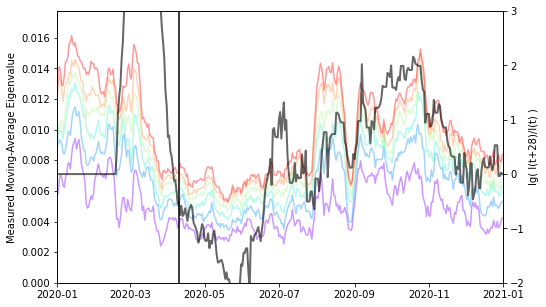

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_ylabel('Measured Moving-Average Eigenvalue')
ax.set_ylim(bottom=0, top=np.max(mavg_eigs)*1.1)
ax.set_xlim(left=DATE_ZERO, right=DATE_ZERO + ntd(mavg_eigs.shape[0]))
#ax.set_xlabel('Days since Jan 1, 2020')
cgen = iter(cm.rainbow(np.linspace(0, 1, eigs.shape[1])))
for i in range(mavg_eigs.shape[1]):
    ax.plot([DATE_ZERO + x for x in ntd(range(mavg_eigs.shape[0]))], mavg_eigs[:, i], c=next(cgen), alpha=.4)
ax2 = ax.twinx()
ax2.set_ylabel("lg( I(t+28)/I(t) )")
ax2.plot([DATE_ZERO + x for x in ntd(range(mavg_eigs.shape[0]))], np.log2(current_state_average_cases[28:mavg_eigs.shape[0]+28] / current_state_average_cases[:mavg_eigs.shape[0]]), c='black',linewidth=2, alpha=.6)
ax2.set_ylim(bottom=-2, top=3)
plt.axvline(x = DATE_ZERO + ntd(START_TIME), color = 'black', label = 'axvline - full height')

plt.savefig("/home/ec2-user/Plots/eigs_" + CURRENT_STATE + ".png", dpi=400, bbox_inches='tight')
plt.show()

# Generate predictors

In [20]:
import prediction_tools
data = {#'3Eigs': (eigs[:, :3], 'exponential'),
        'k=6, l=4': (data_loading.left_looking_multiaverage(eigs[:, :6], 7, 4, replacement='lin'), 'exponential'),
        'k=3, l=1': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 1, replacement='lin'), 'exponential'),
        'k=1, l=3': (data_loading.left_looking_multiaverage(eigs[:, :1], 7, 3, replacement='lin'), 'exponential'),
        'k=3, l=3': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 3, replacement='lin'), 'exponential'),

        'Autoregression': (np.zeros((1000, 1)), 'Autoregression:28,1'),  # Zeros is just placeholder. The predictor will generate the autoregression input from the ratio it knows.
        'SEIR14': (np.append(data_loading.left_looking_multiaverage(np.maximum(current_state_average_cases[:, np.newaxis], 0), 1, 28, replacement='lin'), 14 * np.ones((current_state_cases.shape[0], 1)), axis=1), 'SEIR'),
        'SEIR28': (np.append(data_loading.left_looking_multiaverage(np.maximum(current_state_average_cases[:, np.newaxis], 0), 1, 28, replacement='lin'), 28 * np.ones((current_state_cases.shape[0], 1)), axis=1), 'SEIR'),
        'SEIR42': (np.append(data_loading.left_looking_multiaverage(np.maximum(current_state_average_cases[:, np.newaxis], 0), 1, 28, replacement='lin'), 42 * np.ones((current_state_cases.shape[0], 1)), axis=1), 'SEIR'),
        'SEIR56': (np.append(data_loading.left_looking_multiaverage(np.maximum(current_state_average_cases[:, np.newaxis], 0), 1, 28, replacement='lin'), 56 * np.ones((current_state_cases.shape[0], 1)), axis=1), 'SEIR'),
        
#         '24dNoise': (np.random.normal(size=(1000, 24)), 'exponential'),
        'Null': (np.ones((1000, 1)), 'exponential'),
        'AverageDegree': (num_edges/num_nodes, 'exponential'),
#         'Num nodes': (num_nodes, 'linear'),
#        'Num edges': (num_edges, 'linear'),

#         'Moment ratio': (degree_mom_2/degree_mom_1, 'linear'),
#         'Capped moment ratio': (capped_degree_mom_2/capped_degree_mom_1, 'linear'),
       }

colors = {
    'k=6, l=4': 'darkblue',
    'k=3, l=1': 'deeppink',
    'k=1, l=3': 'teal',
    'k=3, l=3': 'blue',
    
    'Autoregression': 'yellow',
    'AverageDegree': 'orange',
    
    'SEIR14': 'limegreen',
    'SEIR28': 'green',
    'SEIR42': 'forestgreen',
    'SEIR56': 'brown',
    
    '24dNoise': 'gray',
    'Null': 'black',
}

# Summary Statistics

k=6, l=4: Optimal R^2 0.9570938312794884 achieved at offset 48
k=3, l=1: Optimal R^2 0.6386738693762745 achieved at offset 55
k=1, l=3: Optimal R^2 0.7851947861608607 achieved at offset 46
k=3, l=3: Optimal R^2 0.8607643419204167 achieved at offset 52
Autoregression: Optimal R^2 0.2986345633362172 achieved at offset 60
Null: Optimal R^2 1.1102230246251565e-16 achieved at offset 53
AverageDegree: Optimal R^2 0.012934597168752227 achieved at offset 7


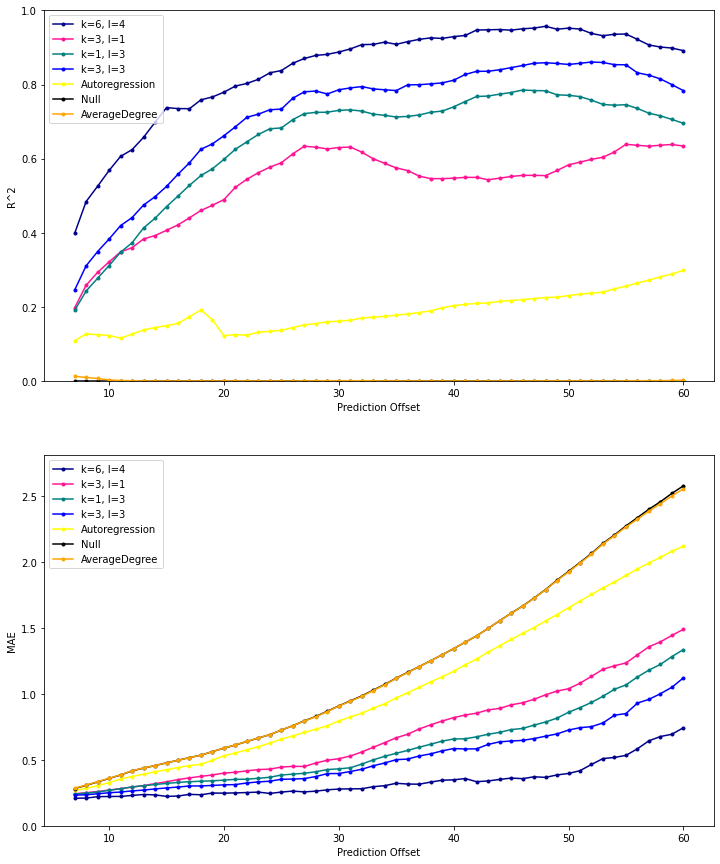

In [21]:
pred = prediction_tools.Predictor({k:v for k, v in data.items() if not k.startswith("SEIR")}, current_state_average_cases, start_time=START_TIME, end_time=END_TIME, verbose=2, graph_state_name=CURRENT_STATE, offset_min=7, offset_max=60, colors=colors)

# Predictions when regressed on the entire dataset beforehand

k=3, l=3: Optimal R^2 0.7824131098410125 achieved at offset 28


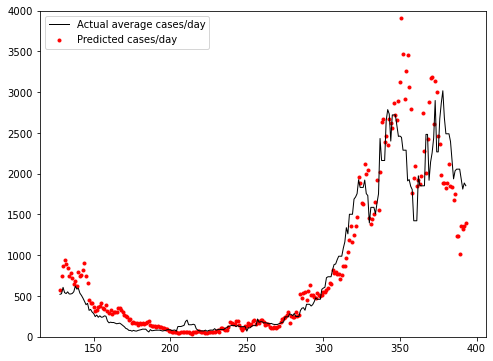

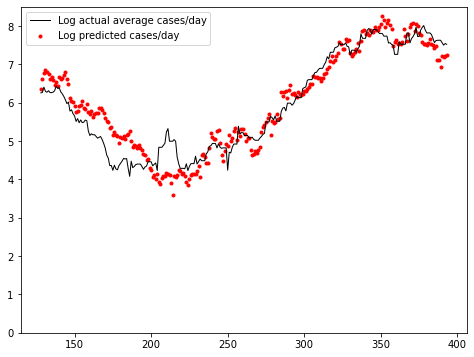

In [22]:
PRED_OFF = 28
pred_data = 'k=3, l=3'
pred = prediction_tools.Predictor({pred_data: data[pred_data]}, current_state_average_cases, start_time=START_TIME, end_time=END_TIME, offset_min=PRED_OFF, offset_max=PRED_OFF, verbose=1)
predictions = current_state_average_cases[START_TIME:END_TIME] * pred.predict(data[pred_data][0][START_TIME:END_TIME], data_name=pred_data)

predictions = np.maximum(predictions, 1)
fix, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), predictions, color='red', marker='.', label='Predicted cases/day')  # Predicted case counts
ax.plot(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), current_state_average_cases[START_TIME+PRED_OFF:END_TIME+PRED_OFF], color='black', label='Actual average cases/day', linewidth=1)  # Actual case counts
ax.legend()
ax.set_ylim(bottom=0, top=4000)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), np.log(predictions), color='red', marker='.', label='Log predicted cases/day')  # Predicted case counts
ax.plot(range(START_TIME+PRED_OFF, END_TIME+PRED_OFF), np.log(current_state_average_cases[START_TIME+PRED_OFF:END_TIME+PRED_OFF]), color='black', linewidth=1, label='Log actual average cases/day')  # Actual case counts
ax.legend()
ax.set_ylim(bottom=0)
plt.show()

# Predictions using only data available on the day of prediction (PRED_OFF days before the actual day)

In [23]:
pred_sources = ['k=3, l=3', 'k=6, l=4']
DIMENSION_OFFSETS = {p : (data[p][0].shape[-1]+1) for p in pred_sources}  # This exists so that we actually have enough points to do a curve fit
AGG_START_OFFSETS = {p:PRED_OFF+DIMENSION_OFFSETS[p]+1+(1) for p in pred_sources}

predictions = {p:np.zeros(current_state_average_cases[START_TIME+AGG_START_OFFSETS[p]:END_TIME].shape) for p in pred_sources}

confidence_intervals = {p:np.zeros((current_state_average_cases[START_TIME+AGG_START_OFFSETS[p]:END_TIME].shape + (2,))) for p in pred_sources}
for p in pred_sources:
    for i in range(START_TIME+AGG_START_OFFSETS[p], END_TIME):
        pred = prediction_tools.Predictor({p: data[p]}, current_state_average_cases, start_time=START_TIME, end_time=i-PRED_OFF, offset_min=PRED_OFF, offset_max=PRED_OFF, verbose=0)
        prediction, ci = pred.predict(data[p][0][i:i+1], data_name=p, return_ci=True)
        prediction = prediction[0]; ci = ci[0]
        prediction *= current_state_average_cases[i]; ci *= current_state_average_cases[i]
        predictions[p][i-AGG_START_OFFSETS[p]-START_TIME], confidence_intervals[p][i-AGG_START_OFFSETS[p]-START_TIME] = prediction, ci
# The predictions array is offset by START_TIME+2*PRED_OFF+DIMENSION_OFFSET (in terms of the time it's predicting). This occurs because we can't actually start predicting until START_TIME+PRED_OFF+DIMENSION_OFFSET.
for p in pred_sources: 
    predictions[p] = np.maximum(predictions[p], 1)

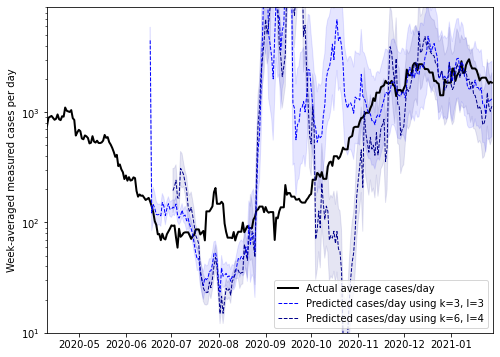

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
pred_sources_to_graph = ['k=3, l=3', 'k=6, l=4']
for p in pred_sources_to_graph:
    x_inds = [DATE_ZERO + x for x in ntd(range(START_TIME+AGG_START_OFFSETS[p]+PRED_OFF, END_TIME+PRED_OFF))]
    ax.errorbar(x_inds, predictions[p], color=colors[p], linestyle='--', linewidth=1, label='Predicted cases/day using '+ p, capsize=1)  # Predicted case counts #"""marker='.',"""
    ax.fill_between(x_inds, np.maximum(confidence_intervals[p][:, 0], 1), confidence_intervals[p][:, 1], alpha=0.1, facecolor=colors[p], edgecolor=colors[p], antialiased=True)
ax.plot([DATE_ZERO + x for x in ntd(range(START_TIME, END_TIME+PRED_OFF))], current_state_average_cases[START_TIME:END_TIME+PRED_OFF], color='black', linewidth=2, label='Actual average cases/day')  # Actual case counts
ax.legend()
ax.set_ylim(bottom=10, top=3 * np.max(current_state_average_cases[START_TIME:END_TIME+PRED_OFF]))
ax.set_xlim(DATE_ZERO + ntd(START_TIME), DATE_ZERO + ntd(END_TIME+PRED_OFF))
ax.set_ylabel("Week-averaged measured cases per day")
SCALE = 'log'
plt.yscale(SCALE,base=10) # Can change this to log
plt.savefig("/home/ec2-user/Plots/pred_nonprescient_" + CURRENT_STATE + "_" + str(PRED_OFF) + "_" + SCALE + ".png", dpi=400, bbox_inches='tight')

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# for p in pred_sources:
#     x_inds = [DATE_ZERO + x for x in ntd(range(START_TIME+2*PRED_OFF+DIMENSION_OFFSETS[p], END_TIME+PRED_OFF))]
#     ax.errorbar(x_inds, np.log10(predictions[p]), color=colors[p], linestyle='-', linewidth=1, label='Predicted cases/day using '+ p, elinewidth=.5, capsize=1)  # Predicted case counts #"""marker='.',"""
#     ax.fill_between(x_inds, np.log10(np.maximum(predictions[p] - ci_radii[p], 1)), np.log10(predictions[p] + ci_radii[p]), alpha=0.2, facecolor=colors[p], edgecolor=colors[p], antialiased=True)
# ax.plot([DATE_ZERO + x for x in ntd(range(START_TIME, END_TIME+PRED_OFF))], np.log10(current_state_average_cases[START_TIME:END_TIME+PRED_OFF]), color='blue', linewidth=1, label='Actual average cases/day')  # Actual case counts
# ax.legend()
# ax.set_ylabel("Week-averaged measured cases per day")
# plt.savefig("/home/ec2-user/Plots/pred_log_nonprescient_" + CURRENT_STATE + "_" + str(PRED_OFF) + ".png", dpi=400, bbox_inches='tight')

# All-state aggregate statistics

In [11]:
import prediction_tools

OFFSET = 28


preds = {}
from data_loading import state_dict

summary_stats = {}
for state in state_dict.keys():
    if state in ['District of Columbia', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands']:
        continue
    print("Starting", state)
    loop_state_cases = data_loading.state_case_data(all_state_case_data, state)
    AVG_PERIOD = 7
    loop_state_average_cases = data_loading.left_looking_moving_average(loop_state_cases, AVG_PERIOD)
    loop_state_average_cases = np.maximum(loop_state_average_cases, 10)
    try:
        eigs, _ = read_data_with_geo_averaging(state, 1, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')
        #print(eigs)
        assert np.mean(eigs) < np.max(eigs) - 1e-6  # Make sure the data is real
        assert np.mean(loop_state_average_cases) < np.max(loop_state_cases) - 1e-6
    except:
        print("Failed to load data for", state)
        continue
    summary_data, _ = read_data_with_geo_averaging(state, WINDOW, 'summary_data/summary_data__')
    num_nodes, num_edges, degree_mom_1, degree_mom_2, capped_degree_mom_1, capped_degree_mom_2 = [summary_data[:, i:i+1] for i in range(summary_data.shape[1])]
    
    data = {#'3Eigs': (eigs[:, :3], 'exponential'),
            'k=6, l=4': (data_loading.left_looking_multiaverage(eigs[:, :6], 7, 4, replacement='lin'), 'exponential'),
            'k=3, l=1': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 1, replacement='lin'), 'exponential'),
            'k=1, l=3': (data_loading.left_looking_multiaverage(eigs[:, :1], 7, 3, replacement='lin'), 'exponential'),
            'k=3, l=3': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 3, replacement='lin'), 'exponential'),
            #'SEIR' + str(OFFSET): (np.append(data_loading.left_looking_multiaverage(np.maximum(loop_state_average_cases[:, np.newaxis], 0), 1, 28, replacement='lin'), OFFSET * np.ones((loop_state_cases.shape[0], 1)), axis=1), 'SEIR'),
            'Autoregression': (np.zeros((1000, 1)), 'Autoregression:28,1'),  # Zeros is just placeholder. The predictor will generate the autoregression input from the ratio it knows.
            # 'BalancedAutoregression': (np.concatenate([np.concatenate([np.zeros((n,)), loop_state_average_cases[n:]/np.maximum(loop_state_average_cases[:-n], 1)], axis=0)[:, np.newaxis] for n in range(7, 29, 7)], axis=-1), 'linear'),
            'AverageDegree': (num_edges/num_nodes, 'linear'),
            # 'Null': (np.ones((1000, 1)), 'exponential'),
           }
    preds[state] = prediction_tools.Predictor(data, loop_state_average_cases, start_time=START_TIME, end_time=END_TIME, offset_min=OFFSET, offset_max=OFFSET, verbose=0)
    
    
    try:
        summary_data, _ = read_data_with_geo_averaging(state, WINDOW, 'summary_data/summary_data__')
        assert np.mean(summary_data) < np.max(summary_data) - 1e-6  # Make sure the data is real
    except:
        print("Failed to load summary data for", state)
        continue
    df_summary = pd.DataFrame(summary_data, columns = ["num_nodes", "num_edges", "degree_mom_1", "degree_mom_2", "capped_degree_mom_1", "capped_degree_mom_2"])
    for cname in ["num_nodes", "num_edges"]:
        df_summary[cname] = df_summary[cname].round()
    summary_stats[state] = df_summary
    
    
available_states = preds.keys()


# Note that we need the autoregression to be done with the linear model to make sense.

Starting Alabama
Starting Alaska
Starting Arizona
Starting Arkansas
Starting California
Starting Colorado
Starting Connecticut
Starting Delaware
Starting Florida
Starting Georgia
Starting Hawaii
Starting Idaho
Starting Illinois
Starting Indiana
Failed to load data for Indiana
Starting Iowa
Starting Kansas
Starting Kentucky
Starting Louisiana
Starting Maine
Starting Maryland
Starting Massachusetts
Starting Michigan
Starting Minnesota
Starting Mississippi
Starting Missouri
Starting Montana
Starting Nebraska
Starting Nevada
Starting New Hampshire
Starting New Jersey
Starting New Mexico
Starting New York
Starting North Carolina
Starting North Dakota
Starting Ohio
Starting Oklahoma
Starting Oregon
Starting Pennsylvania
Starting Rhode Island
Starting South Carolina
Starting South Dakota
Starting Tennessee
Starting Texas
Starting Utah
Starting Vermont
Starting Virginia
Starting Washington
Starting West Virginia
Starting Wisconsin
Starting Wyoming


In [12]:
print("At offset " + str(OFFSET) + ":")

print("R^2:")
for predictor in data.keys():
    avg_r2 = 0
    for state in available_states:
        avg_r2 += preds[state].r2_values[predictor][OFFSET]
    print(predictor + ": " + str(avg_r2 / len(available_states)))
    
print("MAE:")
for predictor in data.keys():
    avg_mae = 0
    for state in available_states:
        avg_mae += preds[state].maes[predictor][OFFSET]
    print(predictor + ": " + str(avg_mae / len(available_states)))


At offset 28:
R^2:
k=6, l=4: 0.7021391906596255
k=3, l=1: 0.16916686021418895
k=1, l=3: 0.15004915310535102
k=3, l=3: 0.35143224125446443
Autoregression: 0.15300122194220656
AverageDegree: 0.04892651403567619
MAE:
k=6, l=4: 0.40701661154572494
k=3, l=1: 0.6898648704656025
k=1, l=3: 0.6901375894971067
k=3, l=3: 0.607771420270937
Autoregression: 0.6878273264484334
AverageDegree: 0.729547360681093


In [13]:
index = state_demographic_data.index
fit_statistics = pd.DataFrame({'state':index}).set_index('state')
for predictor in preds["Connecticut"].optimal_offsets.keys():  # CT here is arbitrary -- could be any state. This is just a way to grab keys
    fit_statistics[predictor + "_offset"] = pd.Series({s:preds[s].optimal_offsets[predictor] for s in available_states}).reindex(index)
    fit_statistics[predictor + '_r2'] = pd.Series({s:preds[s].r2_values[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
    fit_statistics[predictor + '_mae'] = pd.Series({s:preds[s].maes[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
    fit_statistics[predictor + '_mse'] = pd.Series({s:preds[s].mses[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)

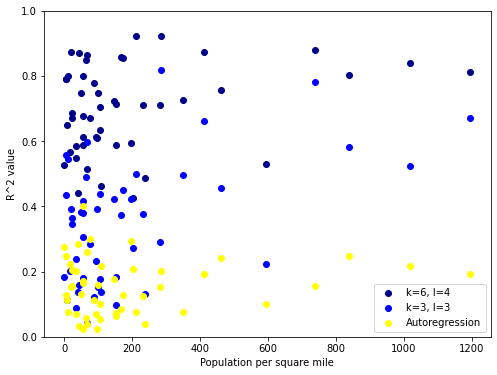

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for predictor in ["k=6, l=4", "k=3, l=3", "Autoregression"]:
    ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics[predictor + "_r2"], c=colors[predictor], label=predictor)
ax.set_xlabel("Population per square mile")
ax.set_ylabel("R^2 value")
ax.set_ylim(0, 1)
ax.legend()
#plt.show()
plt.savefig("/home/ec2-user/Plots/r2_" + str(OFFSET) + ".png", dpi=400, bbox_inches='tight')

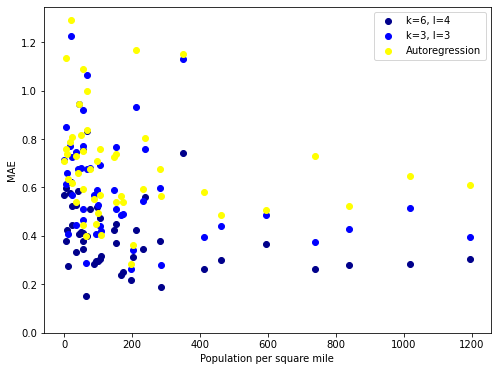

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for predictor in ["k=6, l=4", "k=3, l=3", "Autoregression"]:
    ax.scatter(state_demographic_data['Population.Population per Square Mile'], fit_statistics[predictor + "_mae"], c=colors[predictor], label=predictor)
ax.set_xlabel("Population per square mile")
ax.set_ylabel("MAE")
ax.set_ylim(bottom=0)
ax.legend()
#plt.show()
plt.savefig("/home/ec2-user/Plots/mae_" + str(OFFSET) + ".png", dpi=400, bbox_inches='tight')

# Generating Output Excel Files

In [7]:
import prediction_tools
import os

FILENAME = '/home/ec2-user/all_state_fit_statistics.xlsx'
if os.path.exists(FILENAME):
    os.remove(FILENAME)

writer = pd.ExcelWriter(FILENAME, engine='xlsxwriter')
from data_loading import state_dict
for OFFSET in (14, 28, 42, 56):
    print("Starting offset:", OFFSET)
    preds = {}
    for state in state_dict.keys():  # We reload a bunch here, but that's not horrible on performance, and it's more convenient due to the save format.
        if state in ['District of Columbia', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands']:
            continue
        print("Starting", state)
        loop_state_cases = data_loading.state_case_data(all_state_case_data, state)
        AVG_PERIOD = 7
        loop_state_average_cases = data_loading.left_looking_moving_average(loop_state_cases, AVG_PERIOD)
        loop_state_average_cases = np.maximum(loop_state_average_cases, 10)
        try:
            eigs, _ = read_data_with_geo_averaging(state, 1, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')
            assert np.mean(eigs) < np.max(eigs) - 1e-6  # Make sure the data is real
            assert np.mean(loop_state_average_cases) < np.max(loop_state_cases) - 1e-6
        except:
            print("Failed to load data for", state)
            continue
        #print(loop_state_cases, eigs)




        data = {#'3Eigs': (eigs[:, :3], 'exponential'),
            'k=6, l=4': (data_loading.left_looking_multiaverage(eigs[:, :6], 7, 4, replacement='lin'), 'exponential'),
            'k=3, l=1': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 1, replacement='lin'), 'exponential'),
            'k=1, l=3': (data_loading.left_looking_multiaverage(eigs[:, :1], 7, 3, replacement='lin'), 'exponential'),
            'k=3, l=3': (data_loading.left_looking_multiaverage(eigs[:, :3], 7, 3, replacement='lin'), 'exponential'),
            'SEIR' + str(OFFSET): (np.append(data_loading.left_looking_multiaverage(np.maximum(loop_state_average_cases[:, np.newaxis], 0), 1, 28, replacement='lin'), OFFSET * np.ones((loop_state_cases.shape[0], 1)), axis=1), 'SEIR'),
            'Autoregression': (np.zeros((1000, 1)), 'Autoregression:28,1'),  # Zeros is just placeholder. The predictor will generate the autoregression input from the ratio it knows.
            # 'BalancedAutoregression': (np.concatenate([np.concatenate([np.zeros((n,)), loop_state_average_cases[n:]/np.maximum(loop_state_average_cases[:-n], 1)], axis=0)[:, np.newaxis] for n in range(7, 29, 7)], axis=-1), 'linear'),
            'AverageDegree': (num_edges/num_nodes, 'linear'),
            # 'Null': (np.ones((1000, 1)), 'exponential'),
           }
        preds[state] = prediction_tools.Predictor(data, loop_state_average_cases, start_time=START_TIME, end_time=END_TIME, offset_min=OFFSET, offset_max=OFFSET, verbose=0)
    available_states = preds.keys()
    index = state_demographic_data.index
    fit_statistics = pd.DataFrame({'state':index}).set_index('state')
    for predictor in preds['Connecticut'].optimal_offsets.keys():
        fit_statistics[predictor + "_offset"] = pd.Series({s:preds[s].optimal_offsets[predictor] for s in available_states}).reindex(index)
        fit_statistics[predictor + '_r2'] = pd.Series({s:preds[s].r2_values[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
        fit_statistics[predictor + '_mae'] = pd.Series({s:preds[s].maes[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
        fit_statistics[predictor + '_mse'] = pd.Series({s:preds[s].mses[predictor][preds[s].optimal_offsets[predictor]] for s in available_states}).reindex(index)
    fit_statistics.to_excel(writer, sheet_name='tau=' + str(OFFSET))
    
    fit_stats_table = fit_statistics[[d + '_' + s for d in ['k=6, l=4', 'k=3, l=3', 'Autoregression'] for s in ['r2', 'mae']]].sort_index()
    with open("/home/ec2-user/Plots/fit_stats_table_offset_" + str(OFFSET)+'.tex', 'w') as f:
        f.write(fit_stats_table.to_latex(float_format="%.4f"))
        
    print("At offset " + str(OFFSET) + ":")
    print("R^2:")
    for predictor in data.keys():
        avg_r2 = 0
        for state in available_states:
            avg_r2 += preds[state].r2_values[predictor][OFFSET]
        print(predictor + ": " + str(avg_r2 / len(available_states)))

    print("MAE:")
    for predictor in data.keys():
        avg_mae = 0
        for state in available_states:
            avg_mae += preds[state].maes[predictor][OFFSET]
        print(predictor + ": " + str(avg_mae / len(available_states)))
writer.save()

Starting offset: 14
Starting Alabama
Starting Alaska
Starting Arizona
Starting Arkansas
Starting California
Starting Colorado
Starting Connecticut
Starting Delaware
Starting Florida
Starting Georgia
Starting Hawaii
Starting Idaho
Starting Illinois
Starting Indiana
Failed to load data for Indiana
Starting Iowa
Starting Kansas
Starting Kentucky
Starting Louisiana
Starting Maine
Starting Maryland
Starting Massachusetts
Starting Michigan
Starting Minnesota
Starting Mississippi
Starting Missouri
Starting Montana
Starting Nebraska
Starting Nevada
Starting New Hampshire
Starting New Jersey
Starting New Mexico
Starting New York
Starting North Carolina
Starting North Dakota
Starting Ohio
Starting Oklahoma
Starting Oregon
Starting Pennsylvania
Starting Rhode Island
Starting South Carolina
Starting South Dakota
Starting Tennessee
Starting Texas
Starting Utah
Starting Vermont
Starting Virginia
Starting Washington
Starting West Virginia
Starting Wisconsin
Starting Wyoming
At offset 14:
R^2:
k=6, l=

In [8]:
import os

EIGS_FILENAME = '/home/ec2-user/all_state_eigs_2020.xlsx'
SUMMARY_FILENAME = '/home/ec2-user/all_state_summary_2020.xlsx'
if os.path.exists(EIGS_FILENAME):
    os.remove(EIGS_FILENAME)
if os.path.exists(SUMMARY_FILENAME):
    os.remove(SUMMARY_FILENAME)
eigs_writer = pd.ExcelWriter(EIGS_FILENAME, engine='xlsxwriter')
summary_writer = pd.ExcelWriter(SUMMARY_FILENAME, engine='xlsxwriter')

for state in state_dict.keys():  # We reload a bunch here, but that's not horrible on performance, and it's more convenient due to the save format.
    try:
        eigs, _ = read_data_with_geo_averaging(state, WINDOW, 'eig_data/eigs_from_sum_contacts_by_pairs_laplaciansjl__')
        assert np.mean(eigs) < np.max(eigs) - 1e-6  # Make sure the data is real
    except:
        print("Failed to load eig data for", state)
        continue
    #print(loop_state_cases, eigs)
    df_eigs = pd.DataFrame(eigs, columns = ["lambda_" + str(i) for i in range(1, eigs.shape[1]+1)])
    df_eigs.to_excel(eigs_writer, sheet_name=state)
    
    try:
        summary_data, _ = read_data_with_geo_averaging(state, WINDOW, 'summary_data/summary_data__')
        assert np.mean(summary_data) < np.max(summary_data) - 1e-6  # Make sure the data is real
    except:
        print("Failed to load summary data for", state)
        continue
    df_summary = pd.DataFrame(summary_data, columns = ["num_nodes", "num_edges", "degree_mom_1", "degree_mom_2", "capped_degree_mom_1", "capped_degree_mom_2"])
    for cname in ["num_nodes", "num_edges"]:
        df_summary[cname] = df_summary[cname].round()
    df_summary.to_excel(summary_writer, sheet_name=state)
    
eigs_writer.save()
summary_writer.save()

Failed to load eig data for American Samoa
Failed to load eig data for Guam
Failed to load eig data for Indiana
Failed to load eig data for Northern Mariana Islands
Failed to load eig data for Puerto Rico
Failed to load eig data for Virgin Islands
